In [1]:
import os
import zstandard as zstd
import json
import matplotlib.pyplot as plt
import databento as dbn  # T'as intérêt à avoir installé les libs dbn et zstandard, sinon ça va pas le faire
import pandas as pd

In [9]:

def decompress_zst(zst_path, extract_path):
    """Décompresse un fichier zst comme un boss."""
    with open(zst_path, 'rb') as zst_file:
        dctx = zstd.ZstdDecompressor()
        with open(extract_path, 'wb') as out_file:
            dctx.copy_stream(zst_file, out_file)
    print(f"Bam ! Fichier décompressé dans : {extract_path}")

def load_metadata(metadata_path):
    """Charge les métadonnées du fichier JSON, fastoche."""
    with open(metadata_path, 'r') as f:
        return json.load(f)

def load_symbology(symbology_path):
    """Charge la symbologie du fichier JSON, rien de ouf."""
    with open(symbology_path, 'r') as f:
        return json.load(f)
def visualize_orderbook(dbn_file, symbol):
    """Visualise le carnet d'ordres pour un symbole donné en utilisant @databento."""
    try:
        # On crée un DBNStore à partir du chemin du fichier
        store = dbn.DBNStore.from_file(dbn_file)
        
        # On récupère les données pour le symbole spécifié
        df = store.to_df( # Assurez-vous que c'est le bon schéma pour vos données
        )
    except FileNotFoundError:
        print(f"Erreur : Le fichier {dbn_file} n'a pas été trouvé.")
        return
    except Exception as e:
        print(f"Une erreur s'est produite lors de la lecture du fichier : {str(e)}")
        return
    
    # On vérifie si des données ont été récupérées
    if df.empty:
        print(f"Aucune donnée n'a été trouvée pour le symbole {symbol}")
        return
    
    # On extrait les données pertinentes
    df['timestamp'] = pd.to_datetime(df['ts_event'], unit='ns')
    bids = df[df['side'] == 'B']['price']
    asks = df[df['side'] == 'A']['price']
    timestamps = df['timestamp']
    
    # On balance un graphique de ouf
    plt.figure(figsize=(4, 2))
    plt.scatter(timestamps[df['side'] == 'B'], bids, label='Bid', color='green', alpha=0.5, s=10)
    plt.scatter(timestamps[df['side'] == 'A'], asks, label='Ask', color='red', alpha=0.5, s=10)
    plt.title(f"Carnet d'ordres pour {symbol}, without quantity")
    plt.xlabel("Temps")
    plt.ylabel("Prix")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    # Le chemin vers le dossier avec tous les trucs dedans
    folder_path = "data"
    
    # On décompresse le fichier zst s'il y en a un
    zst_files = [f for f in os.listdir(folder_path) if f.endswith('.zst')]
    if zst_files:
        zst_path = os.path.join(folder_path, zst_files[0])
        extract_path = os.path.join(folder_path, zst_files[0][:-4]+".dbn")  # On enlève l'extension .zst
        decompress_zst(zst_path, extract_path)
    
    # On charge les métadonnées et la symbologie
    metadata = load_metadata(os.path.join(folder_path, "metadata.json"))
    symbology = load_symbology(os.path.join(folder_path, "symbology.json"))
    
    # On cherche le fichier DBN, ça devrait pas trop galère
    dbn_files = [f for f in os.listdir(folder_path) if f.endswith('.dbn')]
    if not dbn_files:
        print("Merde, pas de fichier DBN dans le dossier.")
        return
    
    dbn_file = os.path.join(folder_path, dbn_files[0])
    
    # On visualise le carnet d'ordres pour chaque symbole
    for symbol in symbology['symbols']:
        visualize_orderbook(dbn_file, symbol)


Bam ! Fichier décompressé dans : data/test.dbn


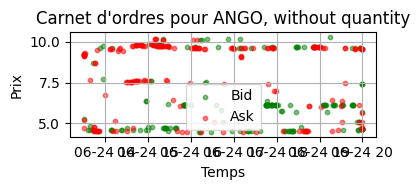

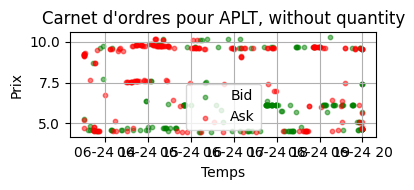

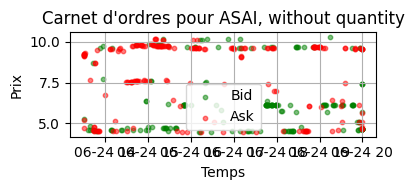

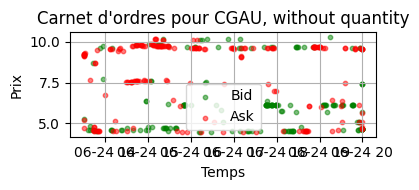

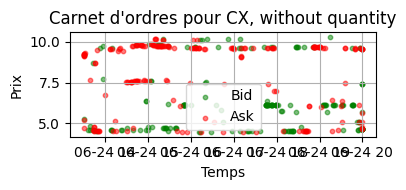

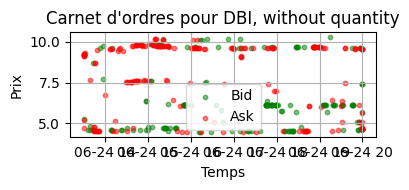

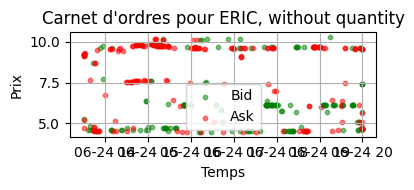

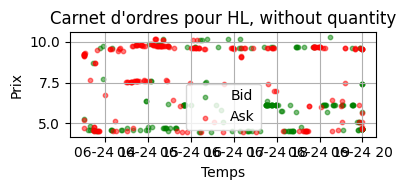

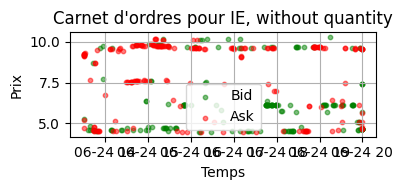

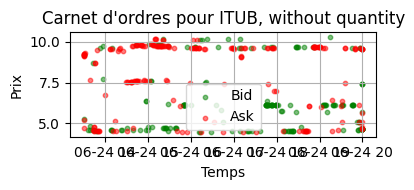

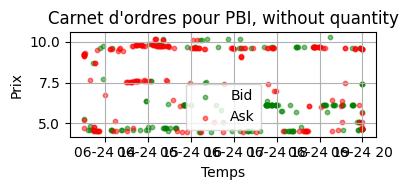

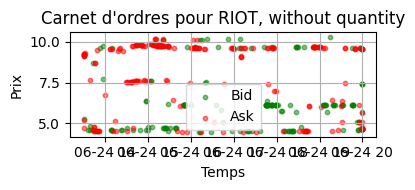

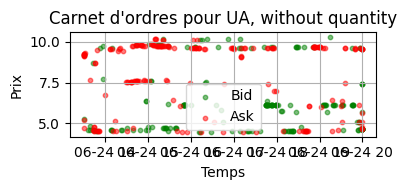

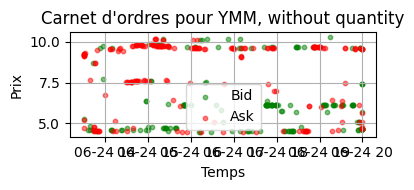

Bam ! Fichier décompressé dans : data/test


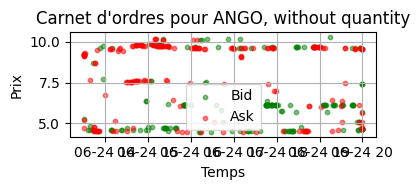

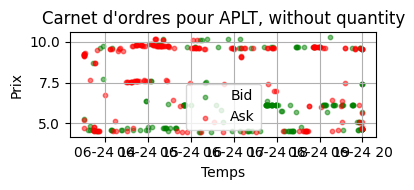

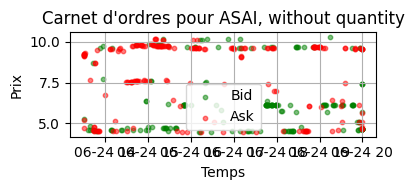

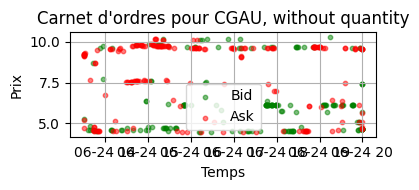

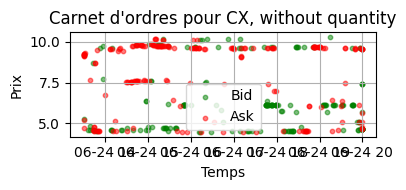

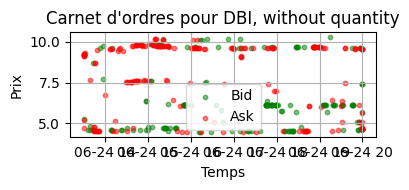

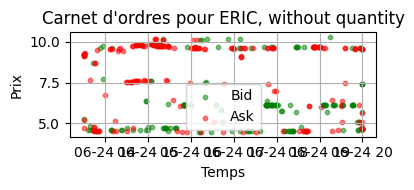

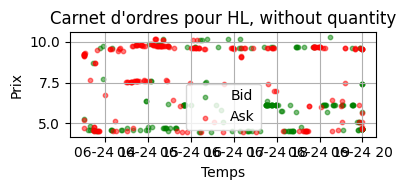

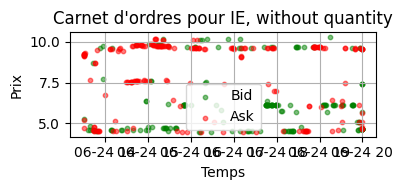

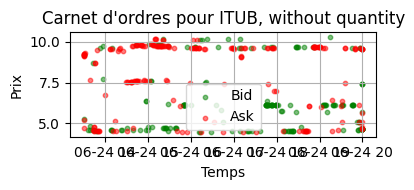

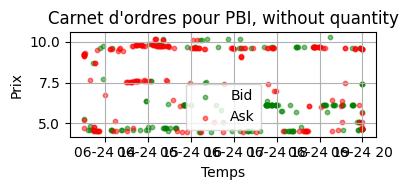

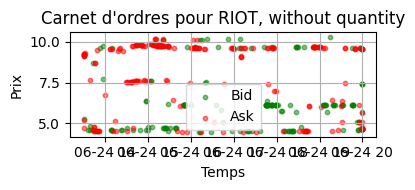

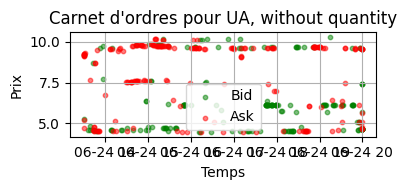

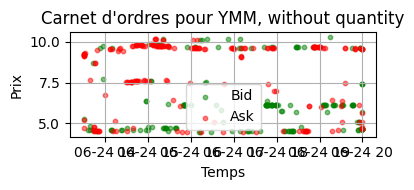

In [10]:

if __name__ == "__main__":
    main()
    
    # On applique le tout à test.zst
    specific_zst_path = "data/test.zst"
    specific_extract_path = specific_zst_path[:-4]  # On enlève l'extension .zst
    decompress_zst(specific_zst_path, specific_extract_path)
    
    # On charge les métadonnées et la symbologie spécifiques si elles existent
    specific_folder = os.path.dirname(specific_zst_path)
    specific_metadata = load_metadata(os.path.join(specific_folder, "metadata.json"))
    specific_symbology = load_symbology(os.path.join(specific_folder, "symbology.json"))
    
    # On cherche le fichier DBN spécifique
    specific_dbn_files = [f for f in os.listdir(specific_folder) if f.endswith('.dbn')]
    if not specific_dbn_files:
        print("Pas de fichier DBN dans le dossier spécifique.")
    else:
        specific_dbn_file = os.path.join(specific_folder, specific_dbn_files[0])
        # On visualise le carnet d'ordres pour chaque symbole spécifique
        for symbol in specific_symbology['symbols']:
            visualize_orderbook(specific_dbn_file, symbol)


In [6]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def visualize_orderbook_histogram(dbn_file, symbol, time_interval=60):
    """
    Visualise l'évolution du carnet d'ordres sous forme d'histogrammes en fonction du temps.
    
    :param dbn_file: Chemin vers le fichier DBN
    :param symbol: Symbole à visualiser
    :param time_interval: Intervalle de temps en secondes pour chaque histogramme
    """
    
    # Initialisation des structures de données
    bid_prices = defaultdict(list)
    bid_quantities = defaultdict(list)
    ask_prices = defaultdict(list)
    ask_quantities = defaultdict(list)
    
    # Lecture du fichier DBN
    with open(dbn_file, 'rb') as f:
        while True:
            message = read_message(f)
            if not message:
                break
            
            if message['type'] == 'L2' and message['symbol'] == symbol:
                timestamp = message['timestamp']
                time_bucket = timestamp // time_interval
                
                for bid in message['bids']:
                    bid_prices[time_bucket].append(bid['price'])
                    bid_quantities[time_bucket].append(bid['quantity'])
                
                for ask in message['asks']:
                    ask_prices[time_bucket].append(-ask['price'])  # Prix négatif pour les asks
                    ask_quantities[time_bucket].append(ask['quantity'])
    
    # Création des histogrammes
    for time_bucket in sorted(bid_prices.keys()):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
        
        # Histogramme des prix
        ax1.hist(bid_prices[time_bucket], bins=50, alpha=0.5, label='Bids')
        ax1.hist(ask_prices[time_bucket], bins=50, alpha=0.5, label='Asks')
        ax1.set_title(f'Distribution des prix à {time_bucket * time_interval} secondes')
        ax1.set_xlabel('Prix (négatif pour les asks)')
        ax1.set_ylabel('Fréquence')
        ax1.legend()
        
        # Histogramme des quantités
        ax2.hist(bid_quantities[time_bucket], bins=50, alpha=0.5, label='Bids')
        ax2.hist(ask_quantities[time_bucket], bins=50, alpha=0.5, label='Asks')
        ax2.set_title(f'Distribution des quantités à {time_bucket * time_interval} secondes')
        ax2.set_xlabel('Quantité')
        ax2.set_ylabel('Fréquence')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()

visualize_orderbook_histogram('data/test.dbn', 'BTCUSD', time_interval=300)
